In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import time
import random
import copy

from scipy import interp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score,accuracy_score, f1_score, recall_score, hamming_loss
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K


#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

print (pd.__version__)

######### DEFINITION OF GLOBAL VARIABLES #########
RUN_CONFIGURATION_LOOP = False

1.2.5


In [4]:
import os 
import sys
#sys.path.append('/')
import circuits


In [5]:
#These functions needed to work with the GraphDecoder/MWPM module
import time

def add_measurement_errs(curr_syn, prob_err, x_syn, depth):
    #x_syn is True if it is x syndrome, False if it is Z syndrome
    total_time = 0
    new_syn = []
    if x_syn:
        for i in curr_syn:
            rand = random.random()
            if rand > prob_err:
                new_syn.append(i)
        return (new_syn + return_xmeasurement_errs(depth, prob_err))
    else:
        for i in curr_syn:
            rand = random.random()
            if rand > prob_err:
                new_syn.append(i)
        return (new_syn + return_zmeasurement_errs(depth, prob_err))
    
def do_new_decoding(data, depth, prob_err):
    decoder = circuits.GraphDecoder(depth,1)
    G = decoder.S['Z']
    #decoder.graph_2D(G,'distance')
    df = pd.DataFrame()
    syn = []
    total_time = 0
    
    for row in data:
        x_input = []
        z_input = []
        x_type = True
        for col in row:
            if not col == "[]":
                col = eval(col)
                for c in col:
                    if x_type:
                        x_input.append(c)
                    else:
                        z_input.append(c)
            x_type = not x_type  
            
        if prob_err > 0:
            syndromes_x = add_measurement_errs(x_input, prob_err, True, depth)
            syndromes_z = add_measurement_errs(z_input, prob_err, False, depth)
        else:
            syndromes_x = x_input
            syndromes_z = z_input

        start = time.time_ns()
        error_graph_x, paths_x = decoder.make_error_graph(syndromes_x,'X')
        matching_graph_x = decoder.matching_graph(error_graph_x,'X')
        matches_x = decoder.matching(matching_graph_x,'X')
        flips_x = decoder.calculate_qubit_flips(matches_x, paths_x,'X')
        syn_x = (translate_errors(flips_x))

        error_graph_z, paths_z = decoder.make_error_graph(syndromes_z,'Z')
        matching_graph_z = decoder.matching_graph(error_graph_z,'Z')
        matches_z = decoder.matching(matching_graph_z,'Z')
        flips_z = decoder.calculate_qubit_flips(matches_z, paths_z,'Z')
        syn_z = translate_errors(flips_z)
        df = df.append(pd.Series([syn_x, syn_z]), ignore_index=True)
        end = time.time_ns()
        total_time += (end - start)/ (10 ** 9)
    return (df, total_time) 

import random
def return_xmeasurement_errs(depth, prob):
    
    new_errs = []
    
    if depth == 3:
        errs = [(0, -0.5, 0.5), (0, 0.5, 1.5), (0, 1.5, 0.5), (0, 2.5, 1.5)]
    elif depth == 5:
        errs = [(0, -0.5, 0.5), (0, 0.5, 1.5), (0, -0.5, 2.5), (0, 0.5, 3.5), (0, 1.5, 0.5), (0, 1.5, 2.5),
                        (0, 2.5, 1.5), (0, 2.5, 3.5), (0, 3.5, 0.5), (0, 4.5, 1.5), (0, 3.5, 2.5), (0, 4.5, 3.5)]
    else:
        errs = [(0, -0.5, 0.5), (0, 0.5, 1.5), (0, -0.5, 2.5), (0, 0.5, 3.5), (0, -0.5, 4.5), (0, 0.5, 5.5),
                        (0, 1.5, 0.5), (0, 1.5, 2.5), (0, 1.5, 4.5), (0, 2.5, 1.5), (0, 2.5, 3.5), (0, 2.5, 5.5),
                        (0, 3.5, 0.5),  (0, 3.5, 2.5), (0, 3.5, 4.5), (0, 4.5, 1.5), (0, 4.5, 3.5), (0, 4.5, 5.5),
                       (0, 5.5, 0.5), (0, 6.5, 1.5), (0, 5.5, 2.5), (0, 6.5, 3.5), (0, 5.5, 4.5), (0, 6.5, 5.5)]
    for e in errs:
        rand = random.random()
        if rand <= prob:
            new_errs.append(e)
            
    return new_errs
            

def return_zmeasurement_errs(depth, prob):
    
    new_errs = []
    
    if depth == 3:
        errs = [(0, 0.5, 0.5), (0, 0.5, 2.5), (0, 1.5, -0.5), (0, 1.5, 1.5)]
    elif depth == 5:
        errs = [(0, 0.5, 0.5), (0, 0.5, 2.5), (0, 0.5, 4.5), (0, 1.5, -0.5), (0, 1.5, 1.5), (0, 1.5, 3.5),
                        (0, 2.5, 0.5), (0, 2.5, 2.5), (0, 2.5, 4.5), (0, 3.5, -0.5), (0, 3.5, 1.5), (0, 3.5, 3.5)]
    else:
        errs = [(0, 0.5, 0.5), (0, 0.5, 2.5), (0, 0.5, 4.5), (0, 0.5, 6.5), (0, 1.5, -0.5), (0, 1.5, 1.5),
                        (0, 1.5, 3.5), (0, 1.5, 5.5), (0, 2.5, 0.5), (0, 2.5, 2.5), (0, 2.5, 4.5), (0, 2.5, 6.5),
                        (0, 3.5, -0.5),  (0, 3.5, 1.5), (0, 3.5, 3.5), (0, 3.5, 5.5), (0, 4.5, 0.5), (0, 4.5, 2.5),
                       (0, 4.5, 4.5), (0, 4.5, 6.5), (0, 5.5, -0.5), (0, 5.5, 1.5), (0, 5.5, 3.5), (0, 5.5, 5.5)]
        
    for e in errs:
        rand = random.random()
        if rand <= prob:
            new_errs.append(e)
            
    return new_errs

def translate_errors (phys_errs):
    flipX = np.array([(0, 1),(1, 0)])
    flipZ = np.array([(1, 0), (0, -1)])
    errs = []
    str2 = ""
    for qubit, flip in phys_errs.items():
        row = int(qubit[1])
        col = int(qubit[2])
        if str(flip) == "X":
            str1 = "X"
        elif str(flip) == "Z":
            str1 = "Z"
        else:
            str1 = "X"
            str2 = "Z"
        str1 += str(row) + str(col)
        errs.append(str1)
        if str2 != "":
            str2 += str(row) +str(col)
            errs.append(str2)
            str2 = ""
    return errs   

def translate_to_graph(df_graph, labels, mlb):
#go through labels given
    indices = []
    labels = mlb.inverse_transform(labels)
    
    for row in labels:
        label_str = str(row)
        for index, r in df_graph.iterrows():
            if label_str == "('',)":
                if str(r["Labels"]) == "[' ']":
                    indices.append([index])
                    break
            if set(row) == set(r["Labels"]):
                indices.append([index])
                break

    df_syns = df_graph.drop(['Labels'], axis=1)
    return_df = pd.DataFrame()
    for i in indices:
        return_df = return_df.append(df_syns.loc[i])
    return return_df

In [6]:
#Function needed for preprocessing. CSV file reads in a string, needs to be a list for labels 
#for preprocessing csv files
def create_list_from_string(err_list):
    newstring = err_list.replace("'", "")
    new_err_list = newstring.strip('][').split(', ')
    return sorted(set(new_err_list))


def create_string_from_list(err_list):
    return_string = "["
    if err_list[0] == "''":
        return "[' ']"
    else:
        for index, i in enumerate(err_list):
            return_string = return_string +  "'" + i + "'"
            if index < (len(err_list)-1):
                return_string += ", "
    return return_string + "]"
        

#take in two 2d arrays of predicted values, true values, and threshold to determine labels. 
#calculates the partial accuracy of the predicted values, averaged out for all obersvations
def partial_accuracy(y_pred, y_true):
    total = 0
    rows = y_pred.shape[0]
    cols = y_pred.shape[1]
    for i in range(0, rows):
        row_correct = 0
        for j in range(0, cols):
            if y_pred[i,j] == y_true[i,j]:
                row_correct += 1
        total += row_correct/cols
    return total/rows

def partial_accuracy_and_contingency(y_pred, y_true, mlb):
    total = 0
    a= np.zeros(shape=y_true.shape)
    rows = y_pred.shape[0]
    cols = y_pred.shape[1]
    df = pd.DataFrame(a, columns = mlb.classes_)
    for i in range(0, rows):
        row_correct = 0
        for j, label in enumerate(mlb.classes_):
            if y_pred[i,j] == y_true[i,j]:
                row_correct += 1
                df.at[i, label] = 1
            else:
                df.at[i, label] = 0

        total += row_correct/cols

    return (total/rows, df)

def contingency_table_and_t (clf1, clf2):
    a = 0 #clf1 pos, clf2 pos
    b = 0 #clf1 pos, clf2 neg
    c = 0 #clf1 neg, clf2 pos
    d = 0 #clf1 neg, clf2 neg
    
    for index, value in clf1.items():
        if value == 1 and clf2[index] == 1:
            a+=1
        elif value == 1 and clf2[index] == 0: #classifier 1 right, classifier 2 wrong
            b+=1
        elif value == 0 and clf2[index] == 1: #classifier 1 wrong, classifier 2 right
            c+=1
        else:
            d+=1
    print("["+str(a)+", "+str(b)+"]")
    print("["+str(c)+", "+str(d)+"]")
    if b == 0 and c ==0:
        print("both b and c are zero")
        t=0
    else:
        t = (((b-c)-1)**2)/(b+c)
    return ([[a,b],[c,d]], t)

def add_noise(val, noise_level):
    rand = random.uniform(0, 1)
    if rand <= noise_level:
        if val == -1:
            val = 1
        elif val == 1:
            val = -1
    return val

In [7]:
#These are super long functions to be hard coded because i dont have time to properly fix them, sorry bout it
#[(0, 0.5, 0.5), (0, 0.5, 2.5), (0, 1.5, -0.5), (0, 1.5, 1.5)]
def graph_with_errs_d3(df):
    x_data = []
    z_data = []
    
    for i in range(len(df)):
        x_data.append([])
        z_data.append([])
        
        if df.loc[i].at["X0"] == -1:
            x_data[i].append((0, -0.5, 0.5))
        if df.loc[i].at["Z1"] == -1:
            z_data[i].append((0, 0.5, 0.5))
        if df.loc[i].at["X2"] == -1:
            x_data[i].append((0, 0.5, 1.5))
        if df.loc[i].at["Z3"] == -1:
            z_data[i].append((0, 0.5, 2.5))
        if df.loc[i].at["Z4"] == -1:
            z_data[i].append((0, 1.5, -0.5))
        if df.loc[i].at["X5"] == -1:
            x_data[i].append((0, 1.5, 0.5))
        if df.loc[i].at["X6"] == -1:
            x_data[i].append((0, 2.5, 1.5))
        if df.loc[i].at["Z7"] == -1:
            z_data[i].append((0, 1.5, 1.5))
        x_data[i] = str(x_data[i])
        z_data[i] = str(z_data[i])
    #graph_df = pd.DataFrame(df["Labels"], x_data, z_data, columns=["Labels", "XSyn", "ZSyn"])
    graph_df = pd.DataFrame({"XSyn":x_data, "ZSyn":z_data})
    return graph_df
        

def graph_with_errs_d5(df):
    x_data = []
    z_data = []
    
    for i in range(len(df)):
        x_data.append([])
        z_data.append([])
        if df.loc[i].at["X0"] == -1:
             x_data[i].append((0, -0.5, 0.5))
        if df.loc[i].at["Z1"] == -1:
            z_data[i].append((0, 0.5, 0.5))
        if df.loc[i].at["X2"] == -1:
            x_data[i].append((0, 0.5, 1.5))
        if df.loc[i].at["X3"] == -1:
            x_data[i].append((0, -0.5, 2.5))
        if df.loc[i].at["Z4"] == -1:
            z_data[i].append((0, 0.5, 2.5))
        if df.loc[i].at["X5"] == -1:
            x_data[i].append((0, 0.5, 3.5))
        if df.loc[i].at["Z6"] == -1:
            z_data[i].append((0, 0.5, 4.5))
        if df.loc[i].at["Z7"] == -1:
            z_data[i].append((0, 1.5, -0.5))
        if df.loc[i].at["X8"] == -1:
            x_data[i].append((0, 1.5, 0.5))
        if df.loc[i].at["Z9"] == -1:
            z_data[i].append((0, 1.5, 1.5))
        if df.loc[i].at["X10"] == -1:
            x_data[i].append((0, 1.5, 2.5))
        if df.loc[i].at["Z11"] == -1:
            z_data[i].append((0, 1.5, 3.5))
        if df.loc[i].at["Z12"] == -1:
            z_data[i].append((0, 2.5, 0.5))
        if df.loc[i].at["X13"] == -1:
            x_data[i].append((0, 2.5, 1.5))
        if df.loc[i].at["Z14"] == -1:
            z_data[i].append((0, 2.5, 2.5))
        if df.loc[i].at["X15"] == -1:
            x_data[i].append((0, 2.5, 3.5))
        if df.loc[i].at["Z16"] == -1:
            z_data[i].append((0, 2.5, 4.5))
        if df.loc[i].at["Z17"] == -1:
            z_data[i].append((0, 3.5, -0.5))
        if df.loc[i].at["X18"] == -1:
            x_data[i].append((0, 3.5, 0.5))
        if df.loc[i].at["X19"] == -1:
            x_data[i].append((0, 4.5, 1.5))
        if df.loc[i].at["Z20"] == -1:
            z_data[i].append((0, 3.5, 1.5))
        if df.loc[i].at["X21"] == -1:
            x_data[i].append((0, 3.5, 2.5))
        if df.loc[i].at["X22"] == -1:
            x_data[i].append((0, 4.5, 3.5))
        if df.loc[i].at["Z23"] == -1:
            z_data[i].append((0, 3.5, 3.5))
        x_data[i] = str(x_data[i])
        z_data[i] = str(z_data[i])
            
    graph_df = pd.DataFrame({"XSyn":x_data, "ZSyn":z_data})
    return graph_df
    
def graph_with_errs_d7(df):
    x_data = []
    z_data = []

    for i in range(len(df)):
        x_data.append([])
        z_data.append([])
        
        if df.loc[i].at["X0"] == -1:
            x_data[i].append((0, -0.5, 0.5))
        if df.loc[i].at["Z1"] == -1:
            z_data[i].append((0, 0.5, 0.5))
        if df.loc[i].at["X2"] == -1:
            x_data[i].append((0, 0.5, 1.5))
        if df.loc[i].at["X3"] == -1:
            x_data[i].append((0, -0.5, 2.5))
        if df.loc[i].at["Z4"] == -1:
            z_data[i].append((0, 0.5, 2.5))
        if df.loc[i].at["X5"] == -1:
            x_data[i].append((0, 0.5, 3.5))
        if df.loc[i].at["X6"] == -1:
            x_data[i].append((0, -0.5, 4.5))
        if df.loc[i].at["Z7"] == -1:
            z_data[i].append((0, 0.5, 4.5))
        if df.loc[i].at["X8"] == -1:
            x_data[i].append((0, 0.5, 5.5))
        if df.loc[i].at["Z9"] == -1:
            z_data[i].append((0, 0.5, 6.5))
        if df.loc[i].at["Z10"] == -1:
            z_data[i].append((0, 1.5, -0.5))
        if df.loc[i].at["X11"] == -1:
            x_data[i].append((0, 1.5, 0.5))
        if df.loc[i].at["Z12"] == -1:
            z_data[i].append((0, 1.5, 1.5))
        if df.loc[i].at["X13"] == -1:
            x_data[i].append((0, 1.5, 2.5))
        if df.loc[i].at["Z14"] == -1:
            z_data[i].append((0, 1.5, 3.5))
        if df.loc[i].at["X15"] == -1:
            x_data[i].append((0, 1.5, 4.5))
        if df.loc[i].at["Z16"] == -1:
            z_data[i].append((0, 1.5, 5.5))
        if df.loc[i].at["Z17"] == -1:
            z_data[i].append((0, 2.5, 0.5))
        if df.loc[i].at["X18"] == -1:
            x_data[i].append((0, 2.5, 1.5))
        if df.loc[i].at["Z19"] == -1:
            z_data[i].append((0, 2.5, 2.5))
        if df.loc[i].at["X20"] == -1:
            x_data[i].append((0, 2.5, 3.5))
        if df.loc[i].at["Z21"] == -1:
            z_data[i].append((0, 2.5, 4.5))
        if df.loc[i].at["X22"] == -1:
            x_data[i].append((0, 2.5, 5.5))
        if df.loc[i].at["Z23"] == -1:
            z_data[i].append((0, 2.5, 6.5))
        if df.loc[i].at["Z24"] == -1:
            z_data[i].append((0, 3.5, -0.5))
        if df.loc[i].at["X25"] == -1:
            x_data[i].append((0, 3.5, 0.5))
        if df.loc[i].at["Z26"] == -1:
            z_data[i].append((0, 3.5, 1.5))
        if df.loc[i].at["X27"] == -1:
            x_data[i].append((0, 3.5, 2.5))
        if df.loc[i].at["Z28"] == -1:
            z_data[i].append((0, 3.5, 3.5))
        if df.loc[i].at["X29"] == -1:
            x_data[i].append((0, 3.5, 4.5))
        if df.loc[i].at["Z30"] == -1:
            z_data[i].append((0, 3.5, 5.5))
        if df.loc[i].at["Z31"] == -1:
            z_data[i].append((0, 4.5, 0.5))
        if df.loc[i].at["X32"] == -1:
            x_data[i].append((0, 4.5, 1.5))
        if df.loc[i].at["Z33"] == -1:
            z_data[i].append((0, 4.5, 2.5))
        if df.loc[i].at["X34"] == -1:
            x_data[i].append((0, 4.5, 3.5))
        if df.loc[i].at["Z35"] == -1:
            z_data[i].append((0, 4.5, 4.5))
        if df.loc[i].at["X36"] == -1:
            x_data[i].append((0, 4.5, 5.5))
        if df.loc[i].at["Z37"] == -1:
            z_data[i].append((0, 4.5, 6.5))
        if df.loc[i].at["Z38"] == -1:
            z_data[i].append((0, 5.5, -0.5))
        if df.loc[i].at["X39"] == -1:
            x_data[i].append((0, 5.5, 0.5))
        if df.loc[i].at["X40"] == -1:
            x_data[i].append((0, 6.5, 1.5))
        if df.loc[i].at["Z41"] == -1:
            z_data[i].append((0, 5.5, 1.5))
        if df.loc[i].at["X42"] == -1:
            x_data[i].append((0, 5.5, 2.5))
        if df.loc[i].at["X43"] == -1:
            x_data[i].append((0, 6.5, 3.5))
        if df.loc[i].at["Z44"] == -1:
            z_data[i].append((0, 5.5, 3.5))
        if df.loc[i].at["X45"] == -1:
            x_data[i].append((0, 5.5, 4.5))
        if df.loc[i].at["X46"] == -1:
            x_data[i].append((0, 6.5, 5.5))
        if df.loc[i].at["Z47"] == -1: 
            z_data[i].append((0, 5.5, 5.5))
        x_data[i] = str(x_data[i])
        z_data[i] = str(z_data[i])
    graph_df = pd.DataFrame({"XSyn":x_data, "ZSyn":z_data})
    return graph_df

In [8]:
#x_d7= trainData_d7.dropna()
#######################################################################################################

#trainData_d7 = pd.read_csv("depth7_all_combos.csv")
#trainData_d7 = trainData_d7.applymap(lambda x: add_noise(x,.01))

#These four lines remove duplicates
#trainData_d7['Labels'] = trainData_d7['Labels'].map(lambda x: create_list_from_string(x))
#trainData_d7['Labels'] = trainData_d7['Labels'].astype(str)
#trainData_d7 = trainData_d7.drop_duplicates('Labels', keep='first', ignore_index=True)
#trainData_d7['Labels'] = trainData_d7['Labels'].map(lambda x: create_list_from_string(x))

#testData_d7_MWPM = graph_with_errs_d7(trainData_d7)

#transforms the data to encoding for ML
#mlb_d7 = MultiLabelBinarizer()
#mlb_d7.fit(trainData_d7['Labels'])
#df = pd.DataFrame(mlb_d7.transform(trainData_d7['Labels']))
#df['Labels']= df.values.tolist()
#trainData_d7 = trainData_d7.drop(['Labels'], axis=1)
#trainData_d7 = pd.concat([df["Labels"],testData_d7_MWPM, trainData_d7], axis=1, ignore_index=True)
#trainData_d7.columns = ["Labels","XSyn", "ZSyn","X0", "Z1", "X2", "X3", "Z4", "X5", "X6", "Z7", "X8", "Z9", "Z10", "X11", "Z12", "X13", "Z14", "X15", "Z16", "Z17", "X18", "Z19","X20", "Z21", "X22", "Z23", "Z24", "X25", "Z26", "X27", "Z28", "X29", "Z30", "Z31", "X32", "Z33", "X34", "Z35", "X36", "Z37", "Z38", "X39", "X40", "Z41", "X42", "X43", "Z44", "X45", "X46", "Z47"]

#######################################################################################

#trainData_d5 = pd.read_csv("depth5_all_combos.csv")
#trainData_d5 = trainData_d5.applymap(lambda x: add_noise(x,.01)) #was .05
#These four lines remove duplicates
#trainData_d5['Labels'] = trainData_d5['Labels'].map(lambda x: create_list_from_string(x))
#trainData_d5['Labels'] = trainData_d5['Labels'].astype(str)
#trainData_d5 = trainData_d5.drop_duplicates('Labels', keep='first', ignore_index=True)
#trainData_d5['Labels'] = trainData_d5['Labels'].map(lambda x: create_list_from_string(x))


#testData_d5_MWPM = graph_with_errs_d5(trainData_d5)


#transforms the data to encoding for ML
#mlb = MultiLabelBinarizer()
#mlb.fit(trainData_d5['Labels'])
#df = pd.DataFrame(mlb.transform(trainData_d5['Labels']))
#df['Labels']= df.values.tolist()
#trainData_d5 = trainData_d5.drop(['Labels'], axis=1)
#trainData_d5 = pd.concat([df["Labels"], testData_d5_MWPM, trainData_d5], axis=1, ignore_index=True)
#trainData_d5.columns = ["Labels","XSyn", "ZSyn","X0","Z1","X2","X3","Z4","X5","Z6","Z7","X8","Z9","X10","Z11","Z12","X13","Z14","X15","Z16","Z17","X18","X19","Z20","X21","X22","Z23"]
#########################################################################################

#Has no duplicates, small enough to check manually
trainData_d3 = pd.read_csv("depth3_all_combos.csv")

trainData_d3["Labels"] = trainData_d3['Labels'].map(lambda x: create_list_from_string(x))
trainData_d3 = trainData_d3.applymap(lambda x: add_noise(x,.01))

testData_d3_MWPM = graph_with_errs_d3(trainData_d3)

mlb_d3 = MultiLabelBinarizer()
mlb_d3.fit(trainData_d3["Labels"])
df = pd.DataFrame(mlb_d3.transform(trainData_d3['Labels']))
df['Labels']= df.values.tolist()
trainData_d3 = trainData_d3.drop(['Labels'], axis=1)
trainData_d3 = pd.concat([df['Labels'], testData_d3_MWPM, trainData_d3], axis=1, ignore_index=True)
trainData_d3.columns = ["Labels","XSyn", "ZSyn", "X0", "Z1", "X2", "Z3", "Z4", "X5", "X6", "Z7"]
#########################################################################################
y_d3 = trainData_d3["Labels"]
x_d3 = trainData_d3.drop(["Labels"], axis=1)

#y_d5 = trainData_d5["Labels"] 
#x_d5 = trainData_d5.drop(["Labels"], axis=1) 

#y_d7 = trainData_d7["Labels"]
#x_d7 = trainData_d7.drop(["Labels"], axis=1)


x_d3 = x_d3.replace([-1], 0)
#x_d5 = x_d5.replace([-1], 0)
#x_d7 = x_d7.replace([-1], 0)

In [30]:
y_d7 = trainData_d7["Labels"] 

In [9]:
#functions for creating lookup tables here:
from collections import defaultdict
from math import log2

def generateAllBinaryStrings(n, arr, i, lookup):  
    if i == n: 
        lookup.setBitStringArray(arr, n)  
        return
      
    # First assign "0" at ith position  
    # and try for all other permutations  
    # for remaining positions  
    arr[i] = 0
    generateAllBinaryStrings(n, arr, i + 1, lookup)  
  
    # And then assign "1" at ith position  , 
    # and try for all other permutations  
    # for remaining positions  
    arr[i] = 1
    generateAllBinaryStrings(n, arr, i + 1, lookup)

class lookup_decoder:
    
    def __init__(self, depth):
        #self.lookupTable = defaultdict()
        self.lookupTable = {}
        self.distributions = {}
        self.depth = depth
        #generating all possible syndrome observations
        #arr = [None] * (depth**2 - 1)
        #generateAllBinaryStrings((depth**2 - 1), arr, 0, self)
        
    def setBitStringArray(self, arr, n): 
        new_str = ""
        for i in range(0, n):  
            new_str += str(arr[i])
        self.lookupTable.update({new_str:defaultdict()})  
        
    def update_table (self, syndrome, phys_errs):
        #all the keys are made in the init, so simply update the physical error combinations for the given syndrome
        if syndrome not in self.lookupTable:
            self.lookupTable[syndrome] = {}
            self.lookupTable[syndrome][phys_errs] = 1
            return
        
        if phys_errs not in self.lookupTable[syndrome]:
            self.lookupTable[syndrome].update({phys_errs: 1})
        else:
            self.lookupTable[syndrome][phys_errs] += 1
     
    def get_probable_error(self, syndrome):
        return_key = []

        if syndrome not in self.lookupTable.keys():
            for i in range(2* int(self.depth**2) + 1):
                return_key.append(0)
            return return_key
        
        key, value = max(self.lookupTable[syndrome].items(), key=lambda x:x[1])
        
        for character in key:
            if character == '0' or character == '1':
                return_key.append(int(character))
                
        return return_key
        
    def make_distribution_graph(self, syn):
        
        plt.bar(list(self.lookupTable[syn].keys()), self.lookupTable[syn].values(), color='g')
        plt.show()
        
    def syndrome_count_graph(self):
        graph_dict = {}
        for syn in self.lookupTable:
            graph_dict.update({syn:sum(self.lookupTable[syn].values())})
        plt.ylim((0,4))
        plt.bar(graph_dict.keys(), graph_dict.values())
        plt.show()
        
    
    def length_of_lookup(self):
        print(len(self.lookupTable))
        
            
    def get_entropies(self):
        entropies = {}
        for syn in self.lookupTable:
            total = sum(self.lookupTable[syn].values())
            h = 0
            for key in self.lookupTable[syn]:
                p = self.lookupTable[syn][key]/total
                h += p+log2(p)
            entropies[syn] = -h
        print(entropies)
            
    def get_syndromes(self):
        return self.lookupTable.keys()
                     
    def print_lookup(self):
        for syn in self.lookupTable:
            print(self.lookupTable[syn])

In [10]:
def train_plut(table, data_x, data_y):
    i = 0
    for index, x in enumerate(data_x):
        syn = "".join([str(i) for i in x])
        syn = syn.replace(".0","")
        labels = np.array2string(np.array(data_y[i]), precision=1, separator='',suppress_small=True).replace("[","").replace("]","")
        table.update_table(syn, labels)
        i+=1
    return table


def test_plut(table, test_set):
    predictions_lookup = []
    for index, x in enumerate(test_set):
        syn_x = "".join([str(i) for i in x])
        syn_x = syn_x.replace(".0","")
        predictions_lookup.append(table.get_probable_error(syn_x))
    return np.array(predictions_lookup)

In [11]:
def compile_FFNN_model_DepthThree(depth):
    model = Sequential()
    layers = 2
    #input layer
    model.add(Dense(8, activation='relu'))
    
    #hidden layers go here
    for i in range(layers):
        model.add(Dense(32, activation='relu'))
    
    model.add(Dense(19 , activation='sigmoid'))
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(learning_rate=0.05),
                  metrics=['accuracy'])
    return model

#make any needed changes here
def compile_FFNN_model_DepthFive(depth):
    model = Sequential()
    layers = 4
    
    #input layer
    model.add(Dense(24, activation='relu'))
    
    #hidden layers go here
    for i in range(layers):
        model.add(Dense(240, activation='relu'))
    
    #model.add(Dense((2*depth**2) , activation='sigmoid'))
    model.add(Dense(51, activation='sigmoid'))
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(learning_rate=0.05),
                  metrics=['accuracy'])
    return model


#make any needed changes here
def compile_FFNN_model_DepthSeven(depth):
    model = Sequential()
    layers = 4
    
    #input layer
    model.add(Dense(48, activation='relu'))
    
    #hidden layers go here
    for i in range(layers):
        model.add(Dense(400, activation='relu'))
    
    #model.add(Dense((2*depth**2) , activation='sigmoid'))
    model.add(Dense(99, activation='sigmoid'))
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
                  metrics=['accuracy'])
    return model


------------------------------------------------------------------------
Training for fold 1 ...


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

<Figure size 720x720 with 0 Axes>

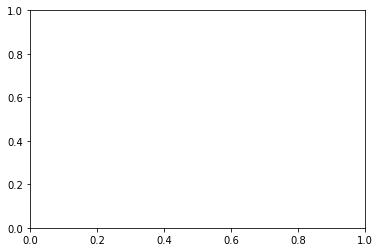

In [12]:
from sklearn.metrics import roc_auc_score
kfold = KFold(n_splits=5, shuffle=True)
inputs = x_d3.copy()
inputs = np.array(inputs)
inputs = np.stack(inputs)
targets = y_d3.copy()
targets = np.array([np.array(xi) for xi in targets])

n_classes = 19

acc_per_fold = []
f1_per_fold = []
time_per_fold = []


acc_per_fold_plut = []
f1_per_fold_plut = []
time_per_fold_plut = []

acc_per_fold_mwpm = []
f1_per_fold_mwpm = []
time_per_fold_mwpm = []


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

aucs_classes = {}
for i in mlb_d3.classes_:
    aucs_classes[i] = []
    
fig, ax = plt.subplots()

#for i in range(5):
    
    # K-fold Cross Validation model evaluation
fold_no = 1
for i, (train, test) in enumerate(kfold.split(inputs, targets)):
    i_train = inputs[train].copy()
    i_test = inputs[test].copy()
    x_test_d3 = i_test[:,:2]
    inputs_train = i_train[:,3:]
    inputs_test = i_test[:,3:]
    ####################################################################################################
    #test MWPM decoder for this fold
    #labels = targets[train], features = inputs[train]
    #x_test_d3 = translate_to_graph(testData_d3_MWPM, targets[test], mlb_d3)
    decoding_d3, time_mwpm = do_new_decoding(x_test_d3, 3, .03)
    decoding_d3['combine'] = decoding_d3[[0, 1]].values.tolist()
    decoding_d3['combine'].apply(lambda x: x[0].extend(x[1]))
    decoding_d3 = np.array(decoding_d3[0])

    time_per_fold_mwpm.append(time_mwpm)

    pred_mwpm = mlb_d3.transform(decoding_d3)
    if fold_no < 5:
        acc = partial_accuracy(targets[test], pred_mwpm)
    else:
        acc, contingency_mwpm = partial_accuracy_and_contingency(targets[test], pred_mwpm, mlb_d3)
        
    acc_per_fold_mwpm.append(acc)
    f1_per_fold_mwpm.append(f1_score(targets[test], pred_mwpm, average='micro'))


    #####################################################################################################
    #test the plut decoder for this fold

    lookup_d3 = lookup_decoder(3)

    lookup_d3 = train_plut(lookup_d3, inputs_train, targets[train])

    start = time.time_ns()
    pred_plut_d3 = test_plut(lookup_d3, inputs_test)
    end = time.time_ns() 
    time_per_fold_plut.append((end - start)/ (10 ** 9))
    
    if fold_no < 5:
        acc = partial_accuracy(targets[test], pred_plut_d3)
    else:
        acc, contingency_plut = partial_accuracy_and_contingency(targets[test], pred_plut_d3, mlb_d3)

    acc_per_fold_plut.append(acc)
    f1_per_fold_plut.append(f1_score(targets[test], pred_plut_d3, average='micro'))

    #####################################################################################################
    #Test the NN decoder for this fold

    model = compile_FFNN_model_DepthThree(3)
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model

    history = model.fit(
        inputs_train, targets[train],
        validation_split=.2,
        epochs=200,
        verbose=1)

   # Generate generalization metrics
    scores = model.evaluate(inputs_test, targets[test], verbose=0)

    #get the time to predicting test
    start = time.time_ns()
    predictions_d3 = model.predict(inputs_test) #change here
    end = time.time_ns()
    time_per_fold.append((end - start)/ (10 ** 9))

    #threshold based on previous tests with train_test_split in hyperparameter tuning
    pred=predictions_d3.copy() #change here
    pred[pred>=.1]=1 
    pred[pred<.1]=0
    
    if fold_no <5:
        acc = scores[1]
    else:
        acc, contingency_nn = partial_accuracy_and_contingency(targets[test], pred, mlb_d3)

    acc_per_fold.append(acc)
    f1_per_fold.append(f1_score(targets[test], pred, average='micro'))

    #####################################################################################################
    #comput ROC AUC for classes and the mircoaverage
    fpr, tpr, thresholds = roc_curve(targets[test].ravel(), predictions_d3.ravel())
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    #get the AUCs of each class, used to get average AUC of each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(targets[test][:, i], predictions_d3[:, i]) #change here
        aucs_classes[mlb_d3.classes_[i]].append(auc(fpr[i], tpr[i]))
        
    # Increase fold number
    fold_no = fold_no + 1
        
#########################################################################################################
#compute McNemar's statistic on results of last fold

mcnemar_results_mwpm = {}
mcnemar_results_plut = {}

for class_ in mlb_d3.classes_:
    
    #compute the x^2 for NN and MWPM
    mcnemar_results_mwpm[class_]=contingency_table_and_t(contingency_nn[class_], contingency_mwpm[class_])[1]    
    #comput the x^2 for NN and PLUT
    mcnemar_results_plut[class_] = contingency_table_and_t(contingency_nn[class_], contingency_plut[class_])[1]
        
    
############print mean and stdev of AUC of each class#####################      
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds of MWPM:')
print(f'> Accuracy: {np.mean(acc_per_fold_mwpm)} (+- {np.std(acc_per_fold_mwpm)})')
print(f'> F1: {np.mean(f1_per_fold_mwpm)}(+- {np.std(f1_per_fold_mwpm)})')
print(f'> Time: {np.mean(time_per_fold_mwpm)} (+- {np.std(time_per_fold_mwpm)})')
print("#####################################################################################")
print('Average scores for all folds of PLUT:')
print(f'> Accuracy: {np.mean(acc_per_fold_plut)} (+- {np.std(acc_per_fold_plut)})')
print(f'> F1: {np.mean(f1_per_fold_plut)}(+- {np.std(f1_per_fold_plut)})')
print(f'> Time: {np.mean(time_per_fold_plut)} (+- {np.std(time_per_fold_plut)})')
print("#####################################################################################")
print('Average scores for all folds of NN:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)}(+- {np.std(f1_per_fold)})')
print(f'> Time: {np.mean(time_per_fold)} (+- {np.std(time_per_fold)})')
print("#####################################################################################")
for key in aucs_classes:
    cleanedList = [x for x in aucs_classes[key] if str(x) != 'nan']
    print(f'> AUC for class {key}: {np.mean(cleanedList)} (+- {np.std(cleanedList)})') #this has to be a for loop
    print("X^2 for MWPM and NN: " + str(mcnemar_results_mwpm[key]))  
    print("X^2 for PLUT and NN: " + str(mcnemar_results_plut[key]))
print("###################################################################################")
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('------------------------------------------------------------------------')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Depth 3 NN',fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [16]:

plt.rcParams.update({'font.size': 22})

model = compile_FFNN_model_DepthThree(3)
print("Fit model on training data")
history = model.fit(
    x=x_train_d3.values,
    y=Y_train_d3,
    validation_split=.25,
    epochs=200
)

Fit model on training data


NameError: name 'x_train_d3' is not defined

In [44]:
"""
# Make a quick epoch vs. loss plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Depth 3 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')"""

"\n# Make a quick epoch vs. loss plot\nplt.figure(figsize=(10,10))\nplt.grid()\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('Depth 3 Model Loss')\nplt.xlabel('Epochs')\nplt.ylabel('Loss (MSE)')"

In [45]:
"""
# Make a quick epoch vs. accuracy plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Depth 3 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')"""

"\n# Make a quick epoch vs. accuracy plot\nplt.figure(figsize=(10,10))\nplt.grid()\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('Depth 3 Model Accuracy')\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')"

In [46]:
"""
start = time.time()
predictions_d3 = model.predict(x_test_d3.values)
end = time.time()
print("Time: " + str(end - start))
# predict

thresholds=[0.1, .2, .3, .4, .5, .6, .7, .8, .9]
for val in thresholds:
    pred=predictions_d3.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0

    precision = precision_score(Y_test_d3, pred, average='micro')
    recall = recall_score(Y_test_d3, pred, average='micro')
    f1 = f1_score(Y_test_d3, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Accuracy = ",accuracy_score(Y_test_d3, pred))
    print("Partial Accuracy = ",partial_accuracy(Y_test_d3, pred))
    print("\n")"""

'\nstart = time.time()\npredictions_d3 = model.predict(x_test_d3.values)\nend = time.time()\nprint("Time: " + str(end - start))\n# predict\n\nthresholds=[0.1, .2, .3, .4, .5, .6, .7, .8, .9]\nfor val in thresholds:\n    pred=predictions_d3.copy()\n  \n    pred[pred>=val]=1\n    pred[pred<val]=0\n\n    precision = precision_score(Y_test_d3, pred, average=\'micro\')\n    recall = recall_score(Y_test_d3, pred, average=\'micro\')\n    f1 = f1_score(Y_test_d3, pred, average=\'micro\')\n   \n    print("Micro-average quality numbers")\n    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))\n    print("Accuracy = ",accuracy_score(Y_test_d3, pred))\n    print("Partial Accuracy = ",partial_accuracy(Y_test_d3, pred))\n    print("\n")'

In [47]:
kfold = KFold(n_splits=5, shuffle=True)
inputs = x_d5.copy()
inputs = np.array(inputs)
inputs = np.stack(inputs)
targets = np.array(y_d5)
#targets = np.stack(targets)
targets = np.array([np.array(xi) for xi in targets])


n_classes = 51

acc_per_fold = []
f1_per_fold = []
time_per_fold = []

acc_per_fold_plut = []
f1_per_fold_plut = []
time_per_fold_plut = []

acc_per_fold_mwpm = []
f1_per_fold_mwpm = []
time_per_fold_mwpm = []

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

aucs_classes = {}
for i in mlb.classes_:
    aucs_classes[i] = []
    
fig, ax = plt.subplots()

# K-fold Cross Validation model evaluation
for i, (train, test) in enumerate(kfold.split(inputs, targets)):
    i_train = inputs[train].copy()
    i_test = inputs[test].copy()
    x_test_d5 = i_test[:,:2]
    inputs_train = i_train[:,3:]
    inputs_test = i_test[:,3:]
    
    ####################################################################################################
    #test MWPM decoder for this fold
    #labels = targets[train], features = inputs[train]
    #x_test_d5 = translate_to_graph(testData_d5_MWPM, targets[test], mlb)
    decoding_d5, time_mwpm = do_new_decoding(x_test_d5, 5, 0)
    decoding_d5['combine'] = decoding_d5[[0, 1]].values.tolist()
    decoding_d5['combine'].apply(lambda x: x[0].extend(x[1]))
    decoding_d5 = np.array(decoding_d5[0])
                                              
    time_per_fold_mwpm.append(time_mwpm)
                                              
    pred_mwpm = mlb.transform(decoding_d5)
    if fold_no < 5:
        acc = partial_accuracy(targets[test], pred_mwpm)
    else:
        acc, contingency_mwpm = partial_accuracy_and_contingency(targets[test], pred_mwpm, mlb)
        
    acc_per_fold_mwpm.append(acc)
    f1_per_fold_mwpm.append(f1_score(targets[test], pred_mwpm, average='micro'))
    
    #####################################################################################################
    #test the plut decoder for this fold
    
    lookup_d5 = lookup_decoder(5)
    
    lookup_d5 = train_plut(lookup_d5, inputs_train, targets[train])
    
    start = time.time_ns()
    pred_plut_d5 = test_plut(lookup_d5, inputs_test)
    end = time.time_ns() 
    time_per_fold_plut.append((end - start)/ (10 ** 9))
    
    if fold_no < 5:
        acc = partial_accuracy(targets[test], pred_plut_d5)
    else:
        acc, contingency_plut = partial_accuracy_and_contingency(targets[test], pred_plut_d5, mlb)
        
    acc_per_fold_plut.append(acc)
    f1_per_fold_plut.append(f1_score(targets[test], pred_plut_d5, average='micro'))

    #####################################################################################################
    #Test the NN decoder for this fold
    
    model_d5 = compile_FFNN_model_DepthFive(5)
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    
    history = model_d5.fit(
    inputs_train,
    targets[train],
    validation_split=.25,
    epochs = 800
)
   # Generate generalization metrics
    scores = model_d5.evaluate(inputs_test, targets[test], verbose=0)
    
    start = time.time_ns()
    predictions_d5 = model_d5.predict(inputs_test)
    end = time.time_ns() 
    time_per_fold.append((end - start)/ (10 ** 9))
    
    #threshold based on previous tests with train_test_split in hyperparameter tuning
    pred=predictions_d5.copy() #change here
    pred[pred>=.4]=1 
    pred[pred<.4]=0
    
    if fold_no < 5:
        acc = scores[1]
    else:
        acc, contingency_nn = partial_accuracy_and_contingency(targets[test], pred, mlb)

    acc_per_fold.append(acc)
    f1_per_fold.append(f1_score(targets[test], pred, average='micro'))

    
    # Increase fold number
    fold_no = fold_no + 1
    
    fpr, tpr, thresholds = roc_curve(targets[test].ravel(), predictions_d5.ravel())
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    #get the AUCs of each class, used to get average AUC of each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(targets[test][:, i], predictions_d5[:, i]) 
        aucs_classes[mlb.classes_[i]].append(auc(fpr[i], tpr[i]))
        
        
#########################################################################################################
#compute McNemar's statistic on results of last fold

mcnemar_results_mwpm = {}
mcnemar_results_plut = {}

for class_ in mlb.classes_:
    
    #compute the x^2 for NN and MWPM
    mcnemar_results_mwpm[class_]=contingency_table_and_t(contingency_nn[class_], contingency_mwpm[class_])[1]    
    #comput the x^2 for NN and PLUT
    mcnemar_results_plut[class_] = contingency_table_and_t(contingency_nn[class_], contingency_plut[class_])[1]
        
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds of MWPM:')
print(f'> Accuracy: {np.mean(acc_per_fold_mwpm)} (+- {np.std(acc_per_fold_mwpm)})')
print(f'> F1: {np.mean(f1_per_fold_mwpm)}(+- {np.std(f1_per_fold_mwpm)})')
print(f'> Time: {np.mean(time_per_fold_mwpm)} (+- {np.std(time_per_fold_mwpm)})')
print("##############################################################################")
print('Average scores for all folds of PLUT:')
print(f'> Accuracy: {np.mean(acc_per_fold_plut)} (+- {np.std(acc_per_fold_plut)})')
print(f'> F1: {np.mean(f1_per_fold_plut)}(+- {np.std(f1_per_fold_plut)})')
print(f'> Time: {np.mean(time_per_fold_plut)} (+- {np.std(time_per_fold_plut)})')
print("##############################################################################")
print('Average scores for all folds of NN:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)}(+- {np.std(f1_per_fold)})')
print(f'> Time: {np.mean(time_per_fold)} (+- {np.std(time_per_fold)})')
print("##############################################################################")
for key in aucs_classes:
    cleanedList = [x for x in aucs_classes[key] if str(x) != 'nan']
    print(f'> AUC for class {key}: {np.mean(cleanedList)} (+- {np.std(cleanedList)})') #this has to be a for loop
    print("X^2 for MWPM and NN: " + str(mcnemar_results_mwpm[key]))  
    print("X^2 for PLUT and NN: " + str(mcnemar_results_plut[key]))
    
print("###################################################################################")
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('------------------------------------------------------------------------')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Depth 5 NN',fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

NameError: name 'x_d5' is not defined

ValueError: Could not interpret optimizer identifier: <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x000001D41CB85F40>

<Figure size 720x720 with 0 Axes>

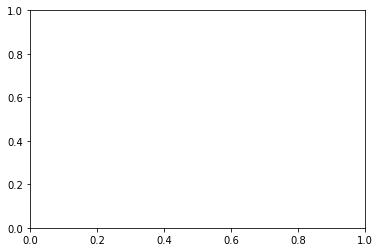

In [21]:
kfold = KFold(n_splits=3, shuffle=True)
inputs = x_d7.copy()
inputs = np.array(inputs)
inputs = np.stack(inputs)
targets = np.array(y_d7)
targets = np.array([np.array(xi) for xi in targets])

n_classes = 99

acc_per_fold = []
f1_per_fold = []
time_per_fold = []

acc_per_fold_plut = []
f1_per_fold_plut = []
time_per_fold_plut = []

acc_per_fold_mwpm = []
f1_per_fold_mwpm = []
time_per_fold_mwpm = []

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

aucs_classes = {}
for i in mlb_d7.classes_:
    aucs_classes[i] = []
    
fig, ax = plt.subplots()

# K-fold Cross Validation model evaluation
fold_no = 1
for i, (train, test) in enumerate(kfold.split(inputs, targets)):
    i_train = inputs[train].copy()
    i_test = inputs[test].copy()
    t_test = targets[test].copy()
    x_test_d7 = i_test[:,:2]
    inputs_train = i_train[:,3:]
    inputs_test = i_test[:,3:]
    indices = np.random.choice(inputs[test].shape[0], 20000, replace=False)
    x_test_d7 = x_test_d7[indices]
    inputs_test_2 = inputs_test[indices]
    targets_test_2 = targets[test][indices]
    ####################################################################################################
    #test MWPM decoder for this fold
    #labels = targets[train], features = inputs[train]
   # x_test_d7 = translate_to_graph(testData_d7_MWPM, targs, mlb_d7)
    decoding_d7, time_mwpm = do_new_decoding(x_test_d7, 7, 0)
    decoding_d7['combine'] = decoding_d7[[0, 1]].values.tolist()
    decoding_d7['combine'].apply(lambda x: x[0].extend(x[1]))
    decoding_d7 = np.array(decoding_d7[0])
                                              
    time_per_fold_mwpm.append(time_mwpm)
                                              
    pred_mwpm = mlb_d7.transform(decoding_d7)

    if fold_no < 3:
        acc = partial_accuracy(targets_test_2, pred_mwpm)
    else:
        acc, contingency_mwpm = partial_accuracy_and_contingency(targets_test_2, pred_mwpm, mlb_d7)
        
    acc_per_fold_mwpm.append(acc)
    f1_per_fold_mwpm.append(f1_score(targets_test_2, pred_mwpm, average='micro'))

    #####################################################################################################
    #test the plut decoder for this fold
    
    lookup_d7 = lookup_decoder(7)
    
    lookup_d7 = train_plut(lookup_d7, inputs_train, targets[train])
    
    start = time.time_ns()
    pred_plut_d7 = test_plut(lookup_d7, inputs_test)
    end = time.time_ns() 
    time_per_fold_plut.append((end - start)/ (10 ** 9))
    
    if fold_no < 3:
        acc = partial_accuracy(targets[test], pred_plut_d7)
        f1 = f1_score(targets[test], pred_plut_d7, average='micro')
    else:
        pred_plut_d7 = test_plut(lookup_d7, inputs_test_2)
        f1 = f1_score(targets_test_2, pred_plut_d7, average='micro')
        acc, contingency_plut = partial_accuracy_and_contingency(targets_test_2, pred_plut_d7, mlb_d7)
        
    acc_per_fold_plut.append(acc)
    f1_per_fold_plut.append(f1)
    
    #####################################################################################################
    #Test the NN decoder for this fold
    
    model_d7 = compile_FFNN_model_DepthSeven(7)

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model_d7.fit(
        x=inputs_train ,
        y=targets[train],
        validation_split=.25,
        epochs= 150)
    
   # Generate generalization metrics
    scores = model_d7.evaluate(inputs_test, targets[test], verbose=0)
    
    start = time.time_ns()
    predictions_d7 = model_d7.predict(inputs_test)
    end = time.time_ns() 
    time_per_fold.append((end - start)/ (10 ** 9))
    
    #threshold based on previous tests with train_test_split in hyperparameter tuning
    pred=predictions_d7.copy() #change here
    pred[pred>=.5]=1 
    pred[pred<.5]=0
     
    if fold_no < 3:
        acc = scores[1]
        f1 = f1_score(targets[test], pred, average='micro')
    else:
        pred = model_d7.predict(inputs_test_2)
        pred[pred>=.5]=1 
        pred[pred<.5]=0
        acc, contingency_nn = partial_accuracy_and_contingency(targets_test_2, pred, mlb_d7)
        f1 = f1_score(targets_test_2, pred, average='micro')
 
    acc_per_fold.append(acc)
    f1_per_fold.append(f1)

    # Increase fold number
    fold_no = fold_no + 1
    
    fpr, tpr, thresholds = roc_curve(targets[test].ravel(), predictions_d7.ravel())
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    #get the AUCs of each class, used to get average AUC of each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(targets[test][:, i], predictions_d7[:, i]) 
        aucs_classes[mlb_d7.classes_[i]].append(auc(fpr[i], tpr[i]))

#########################################################################################################
#compute McNemar's statistic on results of last fold

mcnemar_results_mwpm = {}
mcnemar_results_plut = {}

for class_ in mlb_d7.classes_:
    
    #compute the x^2 for NN and MWPM
    mcnemar_results_mwpm[class_]=contingency_table_and_t(contingency_nn[class_], contingency_mwpm[class_])[1]    
    #comput the x^2 for NN and PLUT
    mcnemar_results_plut[class_] = contingency_table_and_t(contingency_nn[class_], contingency_plut[class_])[1]
        
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds of MWPM:')
print(f'> Accuracy: {np.mean(acc_per_fold_mwpm)} (+- {np.std(acc_per_fold_mwpm)})')
print(f'> F1: {np.mean(f1_per_fold_mwpm)}(+- {np.std(f1_per_fold_mwpm)})')
print(f'> Time: {np.mean(time_per_fold_mwpm)} (+- {np.std(time_per_fold_mwpm)})')
print('Average scores for all folds of PLUT:')
print(f'> Accuracy: {np.mean(acc_per_fold_plut)} (+- {np.std(acc_per_fold_plut)})')
print(f'> F1: {np.mean(f1_per_fold_plut)}(+- {np.std(f1_per_fold_plut)})')
print(f'> Time: {np.mean(time_per_fold_plut)} (+- {np.std(time_per_fold_plut)})')
print('Average scores for all folds of NN:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)}(+- {np.std(f1_per_fold)})')
print(f'> Time: {np.mean(time_per_fold)} (+- {np.std(time_per_fold)})')
for key in aucs_classes:
    cleanedList = [x for x in aucs_classes[key] if str(x) != 'nan']
    print(f'> AUC for class {key}: {np.mean(cleanedList)} (+- {np.std(cleanedList)})') #this has to be a for loop
    print("X^2 for MWPM and NN: " + str(mcnemar_results_mwpm[key]))  
    print("X^2 for PLUT and NN: " + str(mcnemar_results_plut[key]))
print("###################################################################################")
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('------------------------------------------------------------------------')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Depth 7 NN',fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [49]:
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('-----------------------------------------------')

TOTAL F1 NN: []
TOTAL F1 PLUT: [0.2157534077622485]
TOTAL F1 MWPM: [0.7005683482744479]
TOTAL ACC NN: []
TOTAL ACC PLUT: [0.9620832574520717]
TOTAL ACC MWPM: [0.9741898989899191]
TOTAL TIME NN: []
TOTAL TIME PLUT: [6.0671959]
TOTAL TIME MWPM: [10169.34664679988]
-----------------------------------------------


In [ ]:
#test MWPM decoder for this fold
#labels = targets[train], features = inputs[train]
# x_test_d7 = translate_to_graph(testData_d7_MWPM, targs, mlb_d7)
"""
decoding_d7, time_mwpm = do_new_decoding(x_test_d7, 7, 0)
decoding_d7['combine'] = decoding_d7[[0, 1]].values.tolist()
decoding_d7['combine'].apply(lambda x: x[0].extend(x[1]))
decoding_d7 = np.array(decoding_d7[0])

time_per_fold_mwpm.append(time_mwpm)

pred_mwpm = mlb_d7.transform(decoding_d7)

if fold_no < 3:
    acc = partial_accuracy(targets_test_2, pred_mwpm)
else:
    acc, contingency_mwpm = partial_accuracy_and_contingency(targets_test_2, pred_mwpm, mlb_d7)"""

#acc_per_fold_mwpm.append(acc)
#f1_per_fold_mwpm.append(f1_score(targets_test_2, pred_mwpm, average='micro'))

#####################################################################################################
#test the plut decoder for this fold

#lookup_d7 = lookup_decoder(7)

#lookup_d7 = train_plut(lookup_d7, inputs_train, targets[train])

#start = time.time_ns()
#pred_plut_d7 = test_plut(lookup_d7, inputs_test)
#end = time.time_ns() 
#time_per_fold_plut.append((end - start)/ (10 ** 9))

pred_plut_d7 = test_plut(lookup_d7, inputs_test_2)
#f1 = f1_score(targets_test_2, pred_plut_d7, average='micro')
acc, contingency_plut = partial_accuracy_and_contingency(targets_test_2, pred_plut_d7, mlb_d7)

#acc_per_fold_plut.append(acc)
#f1_per_fold_plut.append(f1)

#####################################################################################################
#Test the NN decoder for this fold
"""
model_d7 = compile_FFNN_model_DepthSeven(7)

# Generate a print
print('------------------------------------------------------------------------')
print(f'Training for fold {fold_no} ...')

# Fit data to model
history = model_d7.fit(
    x=inputs_train ,
    y=targets[train],
    validation_split=.25,
    epochs= 150)"""

fpr, tpr, thresholds = roc_curve(targets[test].ravel(), predictions_d7.ravel())
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#get the AUCs of each class, used to get average AUC of each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets[test][:, i], predictions_d7[:, i]) 
    aucs_classes[mlb_d7.classes_[i]].append(auc(fpr[i], tpr[i]))

#########################################################################################################
#compute McNemar's statistic on results of last fold

mcnemar_results_mwpm = {}
mcnemar_results_plut = {}

for class_ in mlb_d7.classes_:
    
    #compute the x^2 for NN and MWPM
    mcnemar_results_mwpm[class_]=contingency_table_and_t(contingency_nn[class_], contingency_mwpm[class_])[1]    
    #comput the x^2 for NN and PLUT
    mcnemar_results_plut[class_] = contingency_table_and_t(contingency_nn[class_], contingency_plut[class_])[1]
        
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds of MWPM:')
print(f'> Accuracy: {np.mean(acc_per_fold_mwpm)} (+- {np.std(acc_per_fold_mwpm)})')
print(f'> F1: {np.mean(f1_per_fold_mwpm)}(+- {np.std(f1_per_fold_mwpm)})')
print(f'> Time: {np.mean(time_per_fold_mwpm)} (+- {np.std(time_per_fold_mwpm)})')
print('Average scores for all folds of PLUT:')
print(f'> Accuracy: {np.mean(acc_per_fold_plut)} (+- {np.std(acc_per_fold_plut)})')
print(f'> F1: {np.mean(f1_per_fold_plut)}(+- {np.std(f1_per_fold_plut)})')
print(f'> Time: {np.mean(time_per_fold_plut)} (+- {np.std(time_per_fold_plut)})')
print('Average scores for all folds of NN:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)}(+- {np.std(f1_per_fold)})')
print(f'> Time: {np.mean(time_per_fold)} (+- {np.std(time_per_fold)})')
for key in aucs_classes:
    cleanedList = [x for x in aucs_classes[key] if str(x) != 'nan']
    print(f'> AUC for class {key}: {np.mean(cleanedList)} (+- {np.std(cleanedList)})') #this has to be a for loop
    print("X^2 for MWPM and NN: " + str(mcnemar_results_mwpm[key]))  
    print("X^2 for PLUT and NN: " + str(mcnemar_results_plut[key]))
print("###################################################################################")
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('------------------------------------------------------------------------')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Depth 7 NN',fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
#test MWPM decoder for this fold
#labels = targets[train], features = inputs[train]
# x_test_d7 = translate_to_graph(testData_d7_MWPM, targs, mlb_d7)
"""
decoding_d7, time_mwpm = do_new_decoding(x_test_d7, 7, 0)
decoding_d7['combine'] = decoding_d7[[0, 1]].values.tolist()
decoding_d7['combine'].apply(lambda x: x[0].extend(x[1]))
decoding_d7 = np.array(decoding_d7[0])

time_per_fold_mwpm.append(time_mwpm)

pred_mwpm = mlb_d7.transform(decoding_d7)

if fold_no < 3:
    acc = partial_accuracy(targets_test_2, pred_mwpm)
else:
    acc, contingency_mwpm = partial_accuracy_and_contingency(targets_test_2, pred_mwpm, mlb_d7)"""

#acc_per_fold_mwpm.append(acc)
#f1_per_fold_mwpm.append(f1_score(targets_test_2, pred_mwpm, average='micro'))

#####################################################################################################
#test the plut decoder for this fold

#lookup_d7 = lookup_decoder(7)

#lookup_d7 = train_plut(lookup_d7, inputs_train, targets[train])

#start = time.time_ns()
#pred_plut_d7 = test_plut(lookup_d7, inputs_test)
#end = time.time_ns() 
#time_per_fold_plut.append((end - start)/ (10 ** 9))

if fold_no < 3:
    acc = partial_accuracy(targets[test], pred_plut_d7)
    f1 = f1_score(targets[test], pred_plut_d7, average='micro')
else:
    pred_plut_d7 = test_plut(lookup_d7, inputs_test_2)
    #f1 = f1_score(targets_test_2, pred_plut_d7, average='micro')
    acc, contingency_plut = partial_accuracy_and_contingency(targets_test_2, pred_plut_d7, mlb_d7)

#acc_per_fold_plut.append(acc)
#f1_per_fold_plut.append(f1)

#####################################################################################################
#Test the NN decoder for this fold
"""
model_d7 = compile_FFNN_model_DepthSeven(7)

# Generate a print
print('------------------------------------------------------------------------')
print(f'Training for fold {fold_no} ...')

# Fit data to model
history = model_d7.fit(
    x=inputs_train ,
    y=targets[train],
    validation_split=.25,
    epochs= 150)"""

pred = model_d7.predict(inputs_test_2)
pred[pred>=.5]=1 
pred[pred<.5]=0
acc, contingency_nn = partial_accuracy_and_contingency(targets_test_2, pred, mlb_d7)
f1 = f1_score(targets_test_2, pred, average='micro')

#acc_per_fold.append(acc)
f1_per_fold.append(f1)

# Increase fold number
fold_no = fold_no + 1

fpr, tpr, thresholds = roc_curve(targets[test].ravel(), predictions_d7.ravel())
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#get the AUCs of each class, used to get average AUC of each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets[test][:, i], predictions_d7[:, i]) 
    aucs_classes[mlb_d7.classes_[i]].append(auc(fpr[i], tpr[i]))

#########################################################################################################
#compute McNemar's statistic on results of last fold

mcnemar_results_mwpm = {}
mcnemar_results_plut = {}

for class_ in mlb_d7.classes_:
    
    #compute the x^2 for NN and MWPM
    mcnemar_results_mwpm[class_]=contingency_table_and_t(contingency_nn[class_], contingency_mwpm[class_])[1]    
    #comput the x^2 for NN and PLUT
    mcnemar_results_plut[class_] = contingency_table_and_t(contingency_nn[class_], contingency_plut[class_])[1]
        
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds of MWPM:')
print(f'> Accuracy: {np.mean(acc_per_fold_mwpm)} (+- {np.std(acc_per_fold_mwpm)})')
print(f'> F1: {np.mean(f1_per_fold_mwpm)}(+- {np.std(f1_per_fold_mwpm)})')
print(f'> Time: {np.mean(time_per_fold_mwpm)} (+- {np.std(time_per_fold_mwpm)})')
print('Average scores for all folds of PLUT:')
print(f'> Accuracy: {np.mean(acc_per_fold_plut)} (+- {np.std(acc_per_fold_plut)})')
print(f'> F1: {np.mean(f1_per_fold_plut)}(+- {np.std(f1_per_fold_plut)})')
print(f'> Time: {np.mean(time_per_fold_plut)} (+- {np.std(time_per_fold_plut)})')
print('Average scores for all folds of NN:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)}(+- {np.std(f1_per_fold)})')
print(f'> Time: {np.mean(time_per_fold)} (+- {np.std(time_per_fold)})')
for key in aucs_classes:
    cleanedList = [x for x in aucs_classes[key] if str(x) != 'nan']
    print(f'> AUC for class {key}: {np.mean(cleanedList)} (+- {np.std(cleanedList)})') #this has to be a for loop
    print("X^2 for MWPM and NN: " + str(mcnemar_results_mwpm[key]))  
    print("X^2 for PLUT and NN: " + str(mcnemar_results_plut[key]))
print("###################################################################################")
print("TOTAL F1 NN: " + str(f1_per_fold))
print("TOTAL F1 PLUT: " + str(f1_per_fold_plut))
print("TOTAL F1 MWPM: " + str(f1_per_fold_mwpm))
print("TOTAL ACC NN: " + str(acc_per_fold))
print("TOTAL ACC PLUT: " + str(acc_per_fold_plut))
print("TOTAL ACC MWPM: " + str(acc_per_fold_mwpm))
print("TOTAL TIME NN: " + str(time_per_fold))
print("TOTAL TIME PLUT: " + str(time_per_fold_plut))
print("TOTAL TIME MWPM: " + str(time_per_fold_mwpm))
print('------------------------------------------------------------------------')


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Depth 7 NN',fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
"""
model_d5 = compile_FFNN_model_DepthFive(5)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

print("Fit model on training data")
history = model_d5.fit(
    x=x_train_d5.values,
    y=Y_train_d5,
    validation_split=.25,
    epochs = 500
)"""

In [ ]:
"""
# Make a quick epoch vs. loss plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Depth 5 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')"""

In [ ]:
"""
# Make a quick epoch vs. accuracy plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Depth 5 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')"""

In [ ]:
"""
# predict
from sklearn.metrics import precision_score,accuracy_score, f1_score, recall_score, hamming_loss

start = time.time()
predictions_d5 = model_d5.predict(x_test_d5.values)
end = time.time()
print("Time: " + str(end - start))

pred=predictions_d5.copy()

thresholds=[0.1, 0.2, 0.3, .4, .5, .6, .7, .8, .9]
for val in thresholds:
    pred=predictions_d5.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
    
  
    precision = precision_score(Y_test_d5, pred, average='micro')
    recall = recall_score(Y_test_d5, pred, average='micro')
    f1 = f1_score(Y_test_d5, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Accuracy = ",accuracy_score(Y_test_d5, pred))
    print("Accuracy = ",partial_accuracy(Y_test_d5, pred))
    print("\n")"""

In [ ]:
"""
pred=predictions_d5.copy()
from sklearn.metrics import multilabel_confusion_matrix, classification_report
#look at confusion matrix to see what got misclassified    
pred[pred>=.5]=1
pred[pred<.5]=0
multilabel_confusion_matrix(Y_test_d5, pred)
"""

In [ ]:
"""
#look at classifcation report to see what got mislabeled
print(classification_report(Y_test_d5, pred))
"""

In [25]:
model_d7 = compile_FFNN_model_DepthSeven(7)
print("Fit model on training data")
history = model_d7.fit(
    x=x_train_d7.values,
    y=Y_train_d7,
    validation_split=.25,
    epochs= 150
)

NameError: name 'Sequential' is not defined

In [26]:
# Make a quick epoch vs. loss plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Depth 7 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

NameError: name 'plt' is not defined

In [27]:
# Make a quick epoch vs. accuracy plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Depth 7 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

NameError: name 'plt' is not defined

In [28]:
""""""
# predict
from sklearn.metrics import precision_score,accuracy_score, f1_score, recall_score, hamming_loss

start = time.time()
predictions_d7 = model_d7.predict(x_test_d7.values)
end = time.time()
print("Time: " + str(end - start))

pred=predictions_d7.copy()


thresholds=[0.1, 0.2, 0.3, .4, .5, .6, .7, .8, .9]
for val in thresholds:
    pred=predictions_d7.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
    
  
    precision = precision_score(Y_test_d7, pred, average='micro')
    recall = recall_score(Y_test_d7, pred, average='micro')
    f1 = f1_score(Y_test_d7, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print("Accuracy = ",accuracy_score(Y_test_d7, pred))
    print("Accuracy = ",partial_accuracy(Y_test_d7, pred))
    print("\n")

NameError: name 'model_d7' is not defined

In [29]:
"""
predictions_d7 = model_d7.predict(x_test_d7.values)
pred=predictions_d7.copy()

n_classes = 99

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_d7[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_d7.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()"""

'\npredictions_d7 = model_d7.predict(x_test_d7.values)\npred=predictions_d7.copy()\n\nn_classes = 99\n\nfpr = dict()\ntpr = dict()\nroc_auc = dict()\nfor i in range(n_classes):\n    fpr[i], tpr[i], _ = roc_curve(Y_test_d7[:, i], pred[:, i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n\nfpr["micro"], tpr["micro"], _ = roc_curve(Y_test_d7.ravel(), pred.ravel())\nroc_auc["micro"] = auc(fpr["micro"], tpr["micro"])\n    \n# Plot of a ROC curve for a specific class\nfor i in range(n_classes):\n    plt.figure()\n    plt.plot(fpr[i], tpr[i], label=\'ROC curve (area = %0.2f)\' % roc_auc[i])\n    plt.plot([0, 1], [0, 1], \'k--\')\n    plt.xlim([0.0, 1.0])\n    plt.ylim([0.0, 1.05])\n    plt.xlabel(\'False Positive Rate\')\n    plt.ylabel(\'True Positive Rate\')\n    plt.title(\'Receiver operating characteristic example\')\n    plt.legend(loc="lower right")\n    plt.show()'

In [30]:
"""
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()"""

'\n# First aggregate all false positive rates\nall_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))\n\n# Then interpolate all ROC curves at this points\nmean_tpr = np.zeros_like(all_fpr)\n\nfor i in range(n_classes):\n    mean_tpr += interp(all_fpr, fpr[i], tpr[i])\n\n# Finally average it and compute AUC\nmean_tpr /= n_classes\n\nfpr["macro"] = all_fpr\ntpr["macro"] = mean_tpr\nroc_auc["macro"] = auc(fpr["macro"], tpr["macro"])\n\n# Plot all ROC curves\nplt.figure()\nplt.plot(fpr["micro"], tpr["micro"],\n         label=\'micro-average ROC curve (area = {0:0.2f})\'\n               \'\'.format(roc_auc["micro"]),\n         color=\'deeppink\', linestyle=\':\', linewidth=4)\n\nplt.plot([0, 1], [0, 1], \'k--\', lw=2)\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Some extension of Receiver operating characteristic to multi-class\')\nplt.legend(loc="lower right")\nplt.show()'

In [31]:
"""
x_train_d3.to_csv("x_train_d3_01.csv")
x_test_d3.to_csv("x_test_d3_01.csv")
pd.DataFrame(Y_train_d3).to_csv("Y_train_d3_01.csv")
pd.DataFrame(Y_test_d3).to_csv("Y_test_d3_01.csv")

x_train_d5.to_csv("x_train_d5_01.csv")
x_test_d5.to_csv("x_test_d5_01.csv")
pd.DataFrame(Y_train_d5).to_csv("Y_train_d5_01.csv")
pd.DataFrame(Y_test_d5).to_csv("Y_test_d5_01.csv")

x_train_d7.to_csv("x_train_d7_01.csv")
x_test_d7.to_csv("x_test_d7_01.csv")
pd.DataFrame(Y_train_d7).to_csv("Y_train_d7_01.csv")
pd.DataFrame(Y_test_d7).to_csv("Y_test_d7_01.csv")"""

'\nx_train_d3.to_csv("x_train_d3_01.csv")\nx_test_d3.to_csv("x_test_d3_01.csv")\npd.DataFrame(Y_train_d3).to_csv("Y_train_d3_01.csv")\npd.DataFrame(Y_test_d3).to_csv("Y_test_d3_01.csv")\n\nx_train_d5.to_csv("x_train_d5_01.csv")\nx_test_d5.to_csv("x_test_d5_01.csv")\npd.DataFrame(Y_train_d5).to_csv("Y_train_d5_01.csv")\npd.DataFrame(Y_test_d5).to_csv("Y_test_d5_01.csv")\n\nx_train_d7.to_csv("x_train_d7_01.csv")\nx_test_d7.to_csv("x_test_d7_01.csv")\npd.DataFrame(Y_train_d7).to_csv("Y_train_d7_01.csv")\npd.DataFrame(Y_test_d7).to_csv("Y_test_d7_01.csv")'

In [35]:
"""
model_d7.save("model_d7_01.h5")
model_d5.save("model_d5_01.h5")
model.save("model_d3_01.h5")"""

'\nmodel_d7.save("model_d7_01.h5")\nmodel_d5.save("model_d5_01.h5")\nmodel.save("model_d3_01.h5")'